In [1]:
import numpy as np
from qiskit import QuantumCircuit

In [44]:
import numpy as np

def generate_bicycle_ldpc(m, n):
    """
    Generate a bicycle LDPC code.
    Parameters:
        m: Number of rows (check bits).
        n: Number of columns (code bits).
    Returns:
        Hx, Hz: LDPC parity-check matrices for X and Z errors.
    """
    H = np.random.randint(0, 2, (m, n // 2))
    Hx = np.concatenate((H, H), axis=1)
    Hz = np.concatenate((H[:, ::-1], H[:, ::-1]), axis=1)
    return Hx, Hz

def generate_unicycle_ldpc(m, n):
    """
    Generate a unicycle LDPC code.
    Parameters:
        m: Number of rows (check bits).
        n: Number of columns (code bits).
    Returns:
        Hx, Hz: LDPC parity-check matrices for X and Z errors.
    """
    H = np.random.randint(0, 2, (m, n))
    Hx = H
    Hz = H[:, ::-1]  # Reverse the columns for unicycle codes
    return Hx, Hz

def rand_bin_array(K, N):
    arr = np.zeros(N)
    arr[:K]  = 1
    np.random.shuffle(arr)
    return arr

def cyclic_shift_matrix(arr):
    N = len(arr)
    matrix = np.zeros((N, N), dtype=arr.dtype)  # Create a matrix of size N x N
    for i in range(N):
        matrix[i] = np.roll(arr, i)  # Shift the array by i positions
    return matrix

def generate_bicycle_ldpc_1(n, m, k):
    n_sub = int(n/2)
    row = rand_bin_array(k, n_sub)
    c = cyclic_shift_matrix(row)
    return np.concatenate((c, c.T), axis=1)

In [60]:
# H_X matrix from https://arxiv.org/pdf/2405.07242
# Hx = np.array([
#     [1, 0, 0, 0, 1, 0, 0, 0, 1, 1],
#     [0, 1, 0, 0, 0, 1, 1, 0, 0, 1],
#     [0, 0, 1, 1, 0, 0, 0, 1, 0, 1]
# ])

# # H_Z matrix
# Hz = np.array([
#     [1, 0, 0, 0, 0, 1, 0, 1, 0, 1],
#     [0, 1, 0, 1, 0, 0, 0, 0, 1, 1],
#     [0, 0, 1, 0, 1, 0, 1, 0, 0, 1]
# ])

#USE BICYCLE PARITY CHECK MATRICES
Hx = generate_bicycle_ldpc_1(8, 4, 1)
Hz = Hx

### USE STEANE CODE 
# Hx = np.array([
#             [1, 1, 1, 1, 0, 0, 0],
#             [1, 1, 0, 0, 1, 1, 0],
#             [1, 0, 1, 0, 1, 0, 1]
#         ], dtype=int)

# Hz = np.array([
#             [1, 1, 1, 1, 0, 0, 0],
#             [1, 1, 0, 0, 1, 1, 0],
#             [1, 0, 1, 0, 1, 0, 1]
#         ], dtype=int)

zeros = np.zeros(Hx.shape)


In [61]:
H0 = np.concatenate((np.concatenate((Hx, zeros), axis=1), np.concatenate((zeros, Hz), axis=1))) #in the standard form for a CSS code

In [62]:
H0

array([[1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.]])

In [63]:
def get_stabilizers(H_sub, stab):
    all_stab = []
    for n in range(len(H_sub)):
        curr_str = ''
        row = H_sub[n]
        for m in row:
            if m:
                curr_str += stab
            else:
                curr_str += 'I'
        print(curr_str)
        all_stab.append(curr_str)
    return all_stab

In [64]:
get_stabilizers(Hx, 'X')

XIIIXIII
IXIIIXII
IIXIIIXI
IIIXIIIX


['XIIIXIII', 'IXIIIXII', 'IIXIIIXI', 'IIIXIIIX']

In [65]:
def make_stabilizer_circ(Hx, Hz, noise_inject=None, input_qc=None):
    """
    Generate a stabilizer circuit given Hx and Hz. 
    noise_inject: a list of functions which take in a qc and with probability p, adds a single pauli to each qubit. 
    ^The functions in noise_inject are shown in below example, and require error prob and number of data qubits
    as input (so the ancillas will not have errors). 
    
    """
    if input_qc:
        data = input_qc.qregs[0]
        ancilla = input_qc.qregs[1]
        
    qc = QuantumCircuit(Hx.shape[1] + Hx.shape[0] + Hz.shape[0], Hx.shape[0] + Hz.shape[0])
    x_offset = Hx.shape[1]
    z_offset = Hx.shape[1] + Hx.shape[0]

    for i in range(len(Hx)):
        row  = Hx[i]
        #print(row)
        for j in range(len(row)):
            curr = row[j]
            #print(curr)
            if curr:
                #print(i, j, curr)
                qc.cx(j, i + x_offset) #need to track offset
                print("Added X stabilizer from qubit " + str(j) + " to ancilla " + str(i))
                qc.barrier()

    for i in range(len(Hz)):
        row  = Hz[i]
        #print(row)
        for j in range(len(row)):
            curr = row[j]
            #print(curr)
            if curr:
                #print(i, j, curr)
                qc.cz(j, i + z_offset) #need to track offset
                print("Added Z stabilizer from qubit " + str(j) + " to ancilla " + str(i))
                qc.barrier()

    #log where errors were added 
    logs = []
    for f in noise_inject:
        log = None
        logs.append(log)
    #qc.x(10)
    qc.measure(range(Hx.shape[1], Hx.shape[1] + Hx.shape[0] + Hz.shape[0]), range(Hx.shape[0] + Hz.shape[0]))
    if input_qc:
        qc = input_qc.append(qc)
    if noise_inject:
        return qc, logs
    else:
        return qc

In [66]:
def make_stabilizer_circ_1(Hx, Hz,  qc, noise_inject=None):
    """
    Generate a stabilizer circuit given Hx and Hz. 
    noise_inject: a list of functions which take in a qc and with probability p, adds a single pauli to each qubit. 
    ^The functions in noise_inject are shown in below example, and require error prob and number of data qubits
    as input (so the ancillas will not have errors). 
    
    """
    qc.barrier()
    data = qc.qregs[0]
    ancilla = qc.qregs[1]

    x_offset = 0
    z_offset = Hx.shape[0]
    
    for i in range(len(Hx)):
        row  = Hx[i]
        #print(row)
        for j in range(len(row)):
            curr = row[j]
            #print(curr)
            if curr:
                #print(i, j, curr)
                qc.cx(data[j], ancilla[i]) #need to track offset
                print(j, i)
                print("Added X stabilizer from qubit " + str(j) + " to ancilla " + str(i))
                qc.barrier()

    for i in range(len(Hz)):
        row  = Hz[i]
        #print(row)
        for j in range(len(row)):
            curr = row[j]
            #print(curr)
            if curr:
                #print(i, j, curr)
                print(j, i)
                qc.cz(data[j], ancilla[i + z_offset]) #need to track offset
                print("Added Z stabilizer from qubit " + str(j) + " to ancilla " + str(i+ z_offset))
                qc.barrier()

    #log where errors were added 
    logs = []
#     for f in noise_inject:
#         log = None
#         logs.append(log)
    #qc.x(10)
    print(ancilla)
    print(qc.cregs[0])
    qc.measure(ancilla, qc.cregs[0])
    if noise_inject:
        return qc, logs
    else:
        return qc

In [67]:
# cd = stac.CommonCodes.generate_code('[[7,1,3]]')
# stac.print_matrix(cd.generator_matrix, augmented=True)
# cd.construct_standard_form()
# stac.print_matrix(cd.standard_generator_matrix, augmented=True)


# cd.construct_logical_operators()
# print("Logical X =", cd.logical_xs)
# stac.print_paulis(cd.logical_xs)

# print("\nLogical Z =", cd.logical_zs)
# stac.print_paulis(cd.logical_zs)

# matrix3 = np.array([
#     [0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
#     [1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0],
#     [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0],
#     [1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0],
#     [0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0],
#     [0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1]
# ])

# matrix4 = np.array([
#     [0, 1, 1, 0, 0, 0, 0, 0],
#     [1, 1, 0, 1, 0, 0, 0, 0],
#     [1, 1, 1, 0, 1, 0, 0, 0],
#     [1, 0, 0, 1, 1, 1, 0, 0],
#     [0, 0, 1, 0, 1, 1, 1, 0],
#     [0, 0, 0, 1, 0, 1, 1, 1]
# ])

In [1]:
import stac
from qiskit import QuantumRegister

# Hx = matrix3
# Hz = Hx


cd = stac.Code(np.concatenate((Hx, zeros)).astype(int), np.concatenate((zeros, Hz)).astype(int))

#cd = stac.Code(Hx.astype(int),Hz.astype(int))
stac.print_matrix(cd.generator_matrix, augmented=True)
cd.construct_logical_operators()
cd.construct_standard_form()
stac.print_matrix(cd.standard_generator_matrix, augmented=True)
print("Logical X =", cd.logical_xs)
print("Logical Z =", cd.logical_zs)


ModuleNotFoundError: No module named 'stac'

In [69]:
# enc_circ = cd.construct_encoding_circuit()
# enc_qc = QuantumCircuit.from_qasm_str(enc_circ.qasm())

# syn_circ= cd.construct_syndrome_circuit()
# syn_qc = QuantumCircuit.from_qasm_str(syn_circ.qasm())

# # ### ADD ERROR 
# # enc_qc.barrier()
# # enc_qc.x(1)
# # enc_qc.barrier()

# qr2 = QuantumRegister(len(enc_qc.qregs[0]))
# enc_qc.add_register(qr2)
# qc = make_stabilizer_circ_1(Hx, Hz, enc_qc)
# qc.draw(output="mpl")

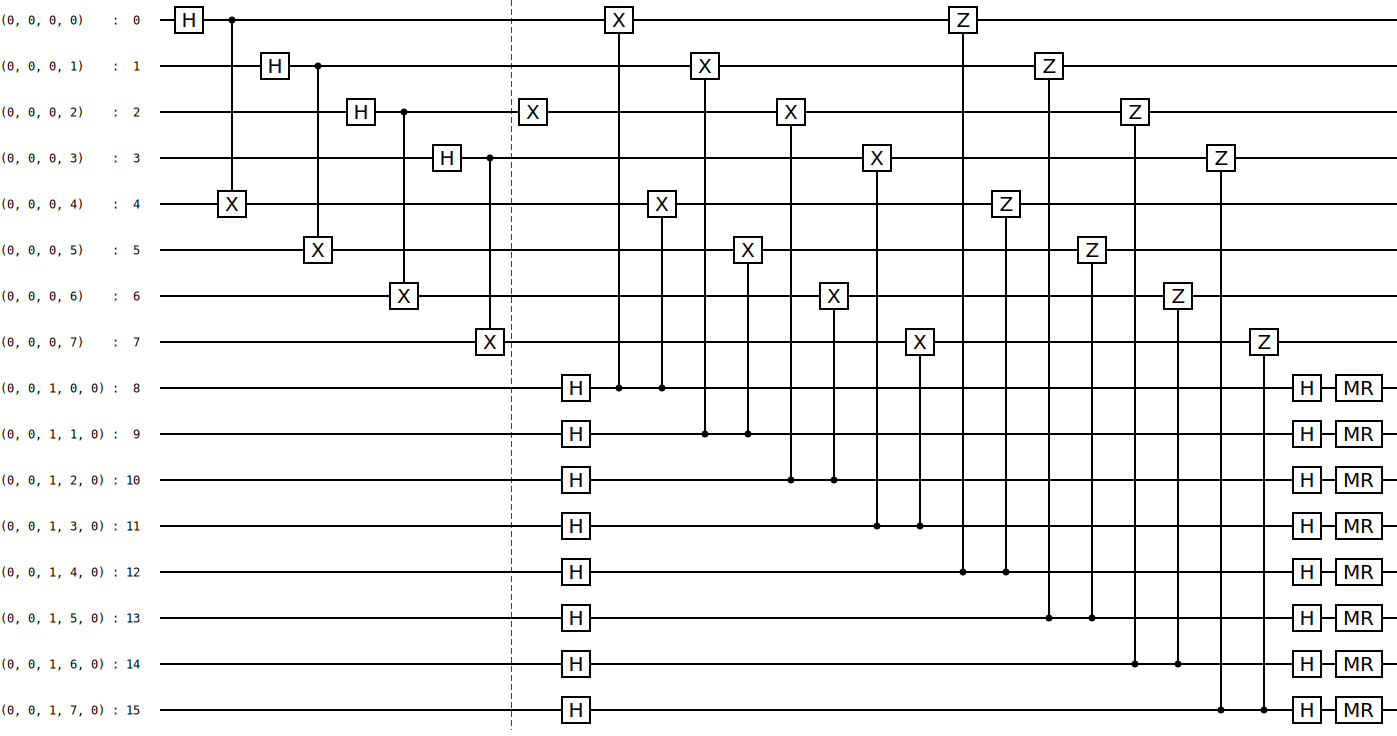

In [70]:
circ = cd.construct_encoding_circuit('non_ft')
circ.append('TICK')

# Step 2
#circ.append('Z', 2)
circ.append('X', 2)

# Step 3
cd.construct_syndrome_circuit();
circ += cd.syndrome_circuit

circ.draw()


In [71]:
circ = QuantumCircuit.from_qasm_str(circ.qasm())

In [72]:
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator, Aer
from qiskit_aer.primitives import EstimatorV2
from qiskit import transpile

In [73]:
def add_random_x_gate(circuit, p, n):
    """
    Randomly applies an X gate to each qubit in the quantum circuit with probability p.
    
    Parameters:
    - circuit (QuantumCircuit): The quantum circuit to modify.
    - p (float): The probability of applying an X gate to each qubit.
    """
    num_qubits = n
    log = []
    # For each qubit in the circuit, apply an X gate with probability p
    for qubit in range(num_qubits):
        if np.random.random() < p:  # With probability p, apply the X gate
            circuit.x(qubit)  # Apply X gate to the qubit
            log.append(qubit)
    return log
            
def add_random_z_gate(circuit, p, n):
    """
    Randomly applies an Z gate to each qubit in the quantum circuit with probability p.
    
    Parameters:
    - circuit (QuantumCircuit): The quantum circuit to modify.
    - p (float): The probability of applying an z gate to each qubit.
    """
    num_qubits = n
    log = []
    # For each qubit in the circuit, apply a z gate with probability p
    for qubit in range(num_qubits):
        if np.random.random() < p:  # With probability p, apply the z gate
            circuit.z(qubit)  # Apply z gate to the qubit
            log.append(qubit)
        
    return log

# Helper functions to parameterize above in terms of only qc.
def add_x(p, n):
    return lambda qc: add_random_x_gate(qc, p, n)

def add_z(p, n):
    return lambda qc: add_random_z_gate(qc, p, n)

In [74]:
# Transpile the circuit for the qasm simulator

qc = circ

simulator = Aer.get_backend('qasm_simulator')
transpiled_circuit = transpile(qc, backend=simulator)

# Simulate the circuit
job = simulator.run(transpiled_circuit, shots=1024)
result = job.result()
counts = result.get_counts()

# Display the measurement results
print("Measurement results:")
print(counts)

# # Calculate expectation values of stabilizers
# stabilizers = get_stabilizers(Hx, 'X') + get_stabilizers(Hz, 'Z')


# print("\nStabilizer operators:")
# print(stabilizers)

# # Expectation value calculation
# expectation_values = {}
# for stabilizer in stabilizers:
#     pauli_op = SparsePauliOp.from_list([(stabilizer, 1)])
#     exp_val = result.get_counts(qc)
#     expectation_values[stabilizer] = exp_val

# print("\nExpectation values:")
# for stabilizer, value in expectation_values.items():
#     print(f"{stabilizer}: {value}")

Measurement results:
{'0100000000000000': 1024}


In [102]:
# Adjust stabilizers to match the number of measured qubits
num_measured_qubits = len(Hx) + len(Hz)  # Number of stabilizer measurements
aligned_stabilizers = [stabilizer[:num_measured_qubits] for stabilizer in stabilizers]

def compute_stabilizer_expectation(counts, stabilizer):
    expectation = 0
    total_shots = sum(counts.values())

    for bitstring, count in counts.items():
        parity = 1
        for i, char in enumerate(stabilizer[::-1]): #account for little endian-ness!
            if char == 'X':
                parity *= (-1) ** int(bitstring[i])
            if char == 'Z':
                parity *= (-1) ** int(bitstring[i])  # Flip sign based on bit value
        expectation += parity * count

    return expectation / total_shots

# Compute expectation values for aligned stabilizers
print("\nStabilizer Expectation Values:")
for stabilizer in aligned_stabilizers:
    expectation = compute_stabilizer_expectation(counts, stabilizer)
    print(f"{stabilizer}: {expectation}")





Stabilizer Expectation Values:
XXXXII: -1.0
XXIIXX: -1.0
XIXIXI: -1.0
ZZZZII: -1.0
ZZIIZZ: -1.0
ZIZIZI: -1.0


In [225]:
###ok, let's try for noisy simulation
# i removed params and replcaed it with None in pub

from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2 as Sampler
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit import transpile

# Define the noise model
num_shots = 1024
noise_model = NoiseModel()
cx_depolarizing_prob = 0.02

noise_model.add_all_qubit_quantum_error(
    depolarizing_error(cx_depolarizing_prob, 2), ["cx"]
)

# Define the sampler with the noise model
noisy_sampler = Sampler(
    options=dict(backend_options=dict(noise_model=noise_model))
)


# Transpile the circuit for the AerSimulator
simulator = AerSimulator()
pass_manager = generate_preset_pass_manager(3, simulator)
isa_circuit = pass_manager.run(qc)

# Submit the job to the noisy sampler
pub = (isa_circuit, None, num_shots)  # No params required
job = noisy_sampler.run([pub])

# Retrieve and display results
result = job.result()
pub_result = result[0]

# Retrieve and print counts
counts = pub_result.data.c.get_counts()
print("Noisy simulation counts:")
print(counts)


Noisy simulation counts:
{'00000100': 845, '00000101': 14, '00000000': 32, '00001100': 51, '00000110': 35, '00000111': 15, '00001001': 1, '00001101': 9, '00000010': 10, '00001110': 2, '00001000': 9, '00000001': 1}


In [226]:
from qiskit_aer.noise import NoiseModel, depolarizing_error, pauli_error, amplitude_damping_error

def create_noise_model(noise_type="depolarizing", prob=0.01):
    # Create different noise models.
    noise_model = NoiseModel()

    if noise_type == "depolarizing":
        noise_model.add_all_qubit_quantum_error(depolarizing_error(prob, 1), ["u1", "u2", "u3"])
        noise_model.add_all_qubit_quantum_error(depolarizing_error(prob, 2), ["cx"])
    elif noise_type == "bit_flip":
        noise_model.add_all_qubit_quantum_error(pauli_error([("X", prob), ("I", 1 - prob)]), ["u1", "u2", "u3"])
    elif noise_type == "amplitude_damping":
        noise_model.add_all_qubit_quantum_error(amplitude_damping_error(prob), ["u1", "u2", "u3"])
    else:
        raise ValueError("Unsupported noise type. Choose from 'depolarizing', 'bit_flip', or 'amplitude_damping'.")

    return noise_model

def simulate_noisy_circuit(qc, noise_model, shots=1024):
    # Simulate qc with different noise models
    simulator = AerSimulator()
    transpiled_circuit = transpile(qc, backend=simulator)
    simulator.set_options(noise_model=noise_model)
    job = simulator.run(transpiled_circuit, shots=shots)
    result = job.result()
    return result.get_counts()


def create_noise_model(noise_type="depolarizing", prob=0.01):
    # Create different noise models
    noise_model = NoiseModel()

    if noise_type == "depolarizing":
        noise_model.add_all_qubit_quantum_error(depolarizing_error(prob, 1), ["u1", "u2", "u3"])
        noise_model.add_all_qubit_quantum_error(depolarizing_error(prob, 2), ["cx"])
    elif noise_type == "bit_flip":
        noise_model.add_all_qubit_quantum_error(pauli_error([("X", prob), ("I", 1 - prob)]), ["u1", "u2", "u3"])
    elif noise_type == "amplitude_damping":
        noise_model.add_all_qubit_quantum_error(amplitude_damping_error(prob), ["u1", "u2", "u3"])
    else:
        raise ValueError("Unsupported noise type. Choose from 'depolarizing', 'bit_flip', or 'amplitude_damping'.")

    return noise_model

In [265]:
import stac

cd = stac.Code(Hx.astype(int), Hz.astype(int))
stac.print_matrix(cd.generator_matrix, augmented=True)
cd.construct_logical_operators()
print("Logical X =", cd.logical_xs)
print("Logical Z =", cd.logical_zs)
enc_circ = cd.construct_encoding_circuit()
qasmqc = QuantumCircuit.from_qasm_str(enc_circ.qasm())

<IPython.core.display.Math object>

Logical X = [[0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0]]
Logical Z = [[0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1]]


In [229]:
cd.construct_standard_form()
stac.print_matrix(cd.standard_generator_matrix, augmented=True)

print("Logical X =", cd.logical_xs)
print("Logical Z =", cd.logical_zs)


<IPython.core.display.Math object>

Logical X = [[0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0]]
Logical Z = [[0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1]]


In [251]:
enc_circ = cd.construct_encoding_circuit()

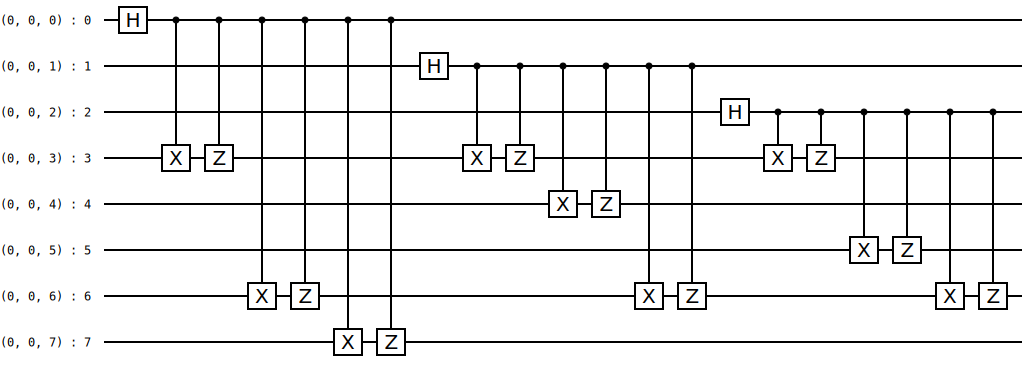

In [252]:
enc_circ.draw()

In [239]:
enc_circ.qasm()

'OPENQASM 2.0;\ninclude "qelib1.inc";\n\nqreg q[8];\ncreg c[8];\n\nh q[0];\ncx q[0],q[3];\ncz q[0],q[3];\ncx q[0],q[6];\ncz q[0],q[6];\ncx q[0],q[7];\ncz q[0],q[7];\nh q[1];\ncx q[1],q[3];\ncz q[1],q[3];\ncx q[1],q[4];\ncz q[1],q[4];\ncx q[1],q[6];\ncz q[1],q[6];\nh q[2];\ncx q[2],q[3];\ncz q[2],q[3];\ncx q[2],q[5];\ncz q[2],q[5];\ncx q[2],q[6];\ncz q[2],q[6];\n'

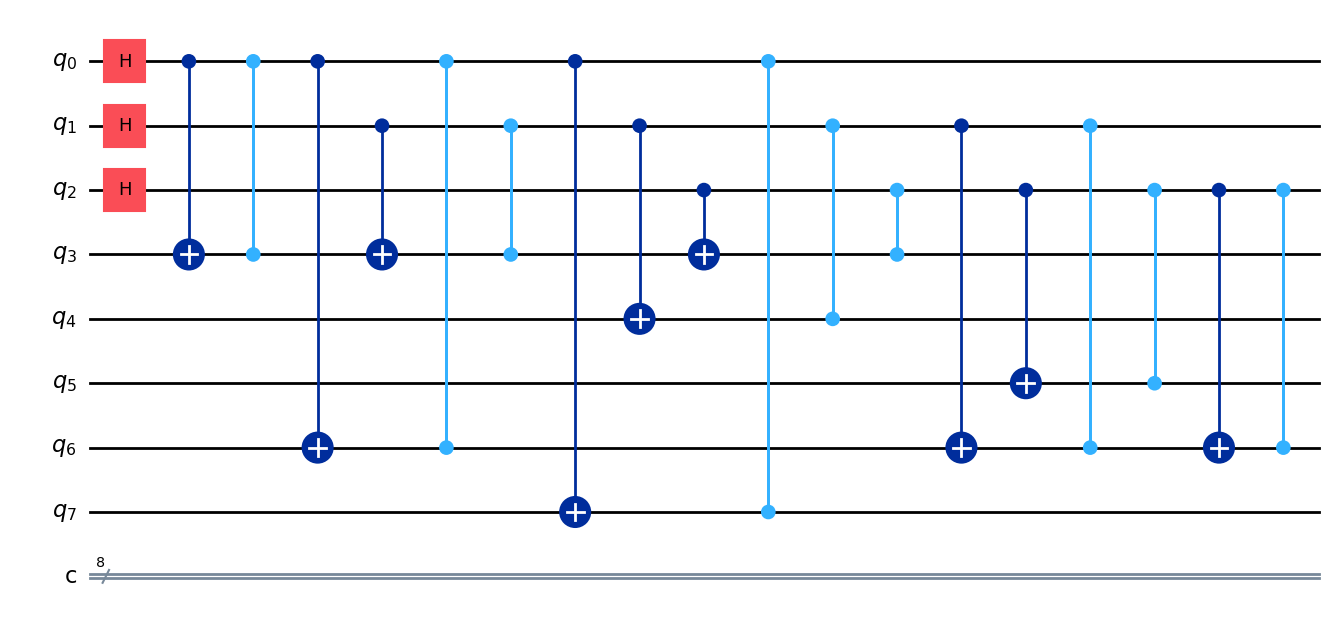

In [253]:
qasmqc.draw(output='mpl')

In [261]:
qasmqc + qc

TypeError: unsupported operand type(s) for +: 'QuantumCircuit' and 'QuantumCircuit'

In [ ]:
### SCRATCH BELOW ###

In [118]:
import stim
import numpy as np
from typing import List


def parity_check_matrix_to_stabilizers(matrix: np.ndarray) -> List[stim.PauliString]:
    num_rows, num_cols = matrix.shape
    assert num_cols % 2 == 0
    num_qubits = num_cols // 2

    matrix = matrix.astype(np.bool)  # indicate the data isn't bit packed
    return [
        stim.PauliString.from_numpy(
            xs=matrix[row, :num_qubits],
            zs=matrix[row, num_qubits:],
        )
        for row in range(num_rows)
    ]

def parity_check_matrix_to_encoder(matrix: np.ndarray) -> stim.Circuit:
    stabilizers = parity_check_matrix_to_stabilizers(matrix)
    tableau = stim.Tableau.from_stabilizers(
        stabilizers,
        allow_underconstrained=True,
        allow_redundant=True
    )
    return tableau.to_circuit(method='elimination')

In [120]:
H0 = np.concatenate((Hx, Hz),axis=1)
circuit_stab = parity_check_matrix_to_encoder(H0)

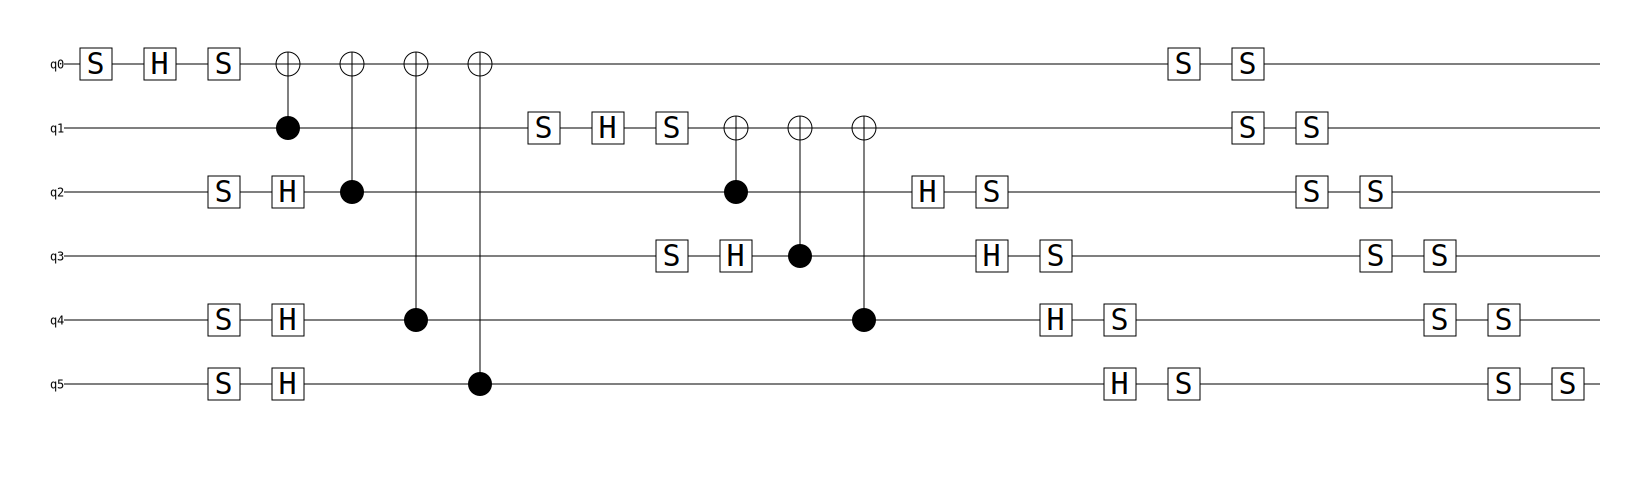

In [121]:
circuit_stab.diagram('timeline-svg')

In [88]:
sampler = circuit_stab.compile_sampler()
print(sampler.sample(shots=100))

[]


In [89]:
sampler

stim.CompiledMeasurementSampler(stim.Circuit('''
    S 0
    H 0
    S 0 2 4 5
    H 2 4 5
    CX 1 0 2 0 4 0 5 0
    S 1
    H 1
    S 1 3
    H 3
    CX 2 1 3 1 4 1
    H 2
    S 2
    H 3
    S 3
    H 4
    S 4
    H 5
    S 5 0 0 1 1 2 2 3 3 4 4 5 5
'''))

In [90]:
circuit = stim.Circuit()

# First, the circuit will initialize a Bell pair.
circuit.append("H", [0])
circuit.append("CNOT", [0, 1])

# Then, the circuit will measure both qubits of the Bell pair in the Z basis.
circuit.append("M", [0, 1])
sampler = circuit.compile_sampler()
print(sampler.sample(shots=10))

[[ True  True]
 [False False]
 [False False]
 [False False]
 [False False]
 [False False]
 [ True  True]
 [False False]
 [False False]
 [ True  True]]


In [245]:
from bposd.css import css_code

In [248]:
from ldpc.codes import hamming_code
from bposd.css import css_code
h=hamming_code(3) #Hamming code parity check matrix
steane_code=css_code(hx=h,hz=h) #create Steane code where both hx and hz are Hamming codes
print("Hx")
print(steane_code.hx)
print("Hz")
print(steane_code.hz)

AttributeError: module 'ldpc' has no attribute 'helpers'